The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l


# Dropout

:label:`sec_dropout`


Just now, we introduced the classical approach
of regularizing statistical models by penalizing
the $\ell_2$ norm of the weights.
In probabilistic terms, we could justify this technique
by arguing that we have assumed a prior belief
that weights take values from a Gaussian distribution with mean $0$.
More intuitively, we might argue
that we encouraged the model to spread out its weights
among many features and rather than depending too much
on a small number of potentially spurious associations.

## Overfitting Revisited

Given many more features than examples, linear models can overfit.
But when there are many more examples than features,
we can generally count on linear models not to overfit.
Unfortunately, the reliability with which linear models generalize
comes at a cost:
Linear models can’t take into account interactions among features.
For every feature, a linear model must assign
either a positive or a negative weight.
They lack the flexibility to account for context.

In more formal text, you’ll see this fundamental tension
between generalizability and flexibility
discussed as the *bias-variance tradeoff*.
Linear models have high bias
(they can only represent a small class of functions),
but low variance (they give similar results
across different random samples of the data).

Deep neural networks take us to the opposite end
of the bias-variance spectrum.
Neural networks are so flexible because
they aren’t confined to looking at each feature individually.
Instead, they can learn interactions among groups of features.
For example, they might infer that “Nigeria” and “Western Union”
appearing together in an email indicates spam
but that “Nigeria” without “Western Union” does not.

Even when we only have a small number of features,
deep neural networks are capable of overfitting.
In 2017, a group of researchers presented a now well-known
demonstration of the incredible flexibility of neural networks.
They presented a neural network with randomly-labeled images
(there was no true pattern linking the inputs to the outputs)
and found that the neural network, optimized by SGD,
could label every image in the training set perfectly.

Consider what this means.
If the labels are assigned uniformly at random and there are 10 classes,
then no classifier can get better than 10% accuracy on holdout data.
Yet even in these situations, when there is no true pattern to be learned, neural networks can perfectly fit the training labels.

## Robustness through Perturbations

Let's think briefly about what we expect from a good statistical model.
We want it to do well on unseen test data.
One way we can accomplish this is by asking
what constitutes a "simple" model?
Simplicity can come in the form
of a small number of dimensions,
which is what we did when discussing fitting a model
with monomial basis functions.
Simplicity can also come in the form
of a small norm for the basis functions.
This led us to weight decay ($\ell_2$ regularization).
Yet a third notion of simplicity that we can impose
is that the function should be robust
under small changes in the input.
For instance, when we classify images,
we would expect that adding some random noise
to the pixels should be mostly harmless.


In 1995, Christopher Bishop formalized
a form of this idea when he proved
that training with input noise is equivalent to Tikhonov regularization :cite:`Bishop.1995`.
In other words, he drew a clear mathematical connection
between the requirement that a function be smooth (and thus simple),
as we discussed in the section on weight decay,
with and the requirement that it be resilient to perturbations in the input.

Then in 2014, Srivastava et al. :cite:`Srivastava.Hinton.Krizhevsky.ea.2014`
developed a clever idea for how to apply Bishop's idea
to the *internal* layers of the network, too.
Namely they proposed to inject noise into each layer of the network
before calculating the subsequent layer during training.
They realized that when training deep network with many layers,
enforcing smoothness just on the input-output mapping
misses out on what is happening internally in the network.
Their proposed idea is called *dropout*,
and it is now a standard technique
that is widely used for training neural networks.
Throughout training, on each iteration,
dropout regularization consists simply of zeroing out
some fraction (typically 50%) of the nodes in each layer
before calculating the subsequent layer.

The key challenge then is how to inject this noise
without introducing undue statistical *bias*.
In other words, we want to perturb the inputs
to each layer during training
in such a way that the expected value of the layer
is equal to the value it would have taken
had we not introduced any noise at all.

In Bishop's case, when we are adding
Gaussian noise to a linear model,
this is simple:
At each training iteration, just add noise
sampled from a distribution with mean zero
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ to the input $\mathbf{x}$ ,
yielding a perturbed point $\mathbf{x}' = \mathbf{x} + \epsilon$.
In expectation, $E[\mathbf{x}'] = \mathbf{x}$.

In the case of dropout regularization,
one can debias each layer
by normalizing by the fraction of nodes that were not dropped out.
In other words, dropout with drop probability $p$ is applied as follows:

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ with probability } p \\
    \frac{h}{1-p} & \text{ otherwise}
\end{cases}
\end{aligned}
$$

By design, the expectation remains unchanged,
i.e., $E[h'] = h$.
Intermediate activations $h$ are replaced by a random variable $h'$
with matching expectation.
The name "dropout" arises from the notion
that some neurons "drop out" of the computation
for the purpose of computing the final result.
During training, we replace intermediate activations with random variables.

## Dropout in Practice

Recall the multilayer perceptron (:numref:`sec_mlp`) with a hidden layer and 5 hidden units. Its architecture is given by

$$
\begin{aligned}
    h & = \sigma(W_1 x + b_1), \\
    o & = W_2 h + b_2, \\
    \hat{y} & = \mathrm{softmax}(o).
\end{aligned}
$$

When we apply dropout to the hidden layer,
we are essentially removing each hidden unit with probability $p$,
(i.e., setting their output to $0$).
We can view the result as a network containing
only a subset of the original neurons.
In :numref:`fig_dropout2`, $h_2$ and $h_5$ are removed.
Consequently, the calculation of $y$ no longer depends on $h_2$ and $h_5$
and their respective gradient also vanishes when performing backprop.
In this way, the calculation of the output layer
cannot be overly dependent on any one element of $h_1, \ldots, h_5$.
Intuitively, deep learning researchers often explain the intuition thusly:
we do not want the network's output to depend
too precariously on the exact activation pathway through the network.
The original authors of the dropout technique
described their intuition as an effort
to prevent the *co-adaptation* of feature detectors.

![MLP before and after dropout](http://d2l.ai/_images/dropout2.svg)

:label:`fig_dropout2`


At test time, we typically do not use dropout.
However, we note that there are some exceptions:
some researchers use dropout at test time as a heuristic approach
for estimating the *confidence* of neural network predictions:
if the predictions agree across many different dropout masks,
then we might say that the network is more confident.
For now we will put off the advanced topic of uncertainty estimation
for subsequent chapters and volumes.


## Implementation from Scratch

To implement the dropout function for a single layer,
we must draw as many samples from a Bernoulli (binary) random variable
as our layer has dimensions, where the random variable takes value $1$ (keep) with probability $1-p$ and $0$ (drop) with probability $p$.
One easy way to implement this is to first draw samples
from the uniform distribution $U[0, 1]$.
then we can keep those nodes for which the corresponding
sample is greater than $p$, dropping the rest.

In the following code, we implement a `dropout` function
that drops out the elements in the `ndarray` input `X`
with probability `drop_prob`,
rescaling the remainder as described above
(dividing the survivors by `1.0-drop_prob`).

In [1]:
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    # In this case, all elements are dropped out
    if drop_prob == 1:
        return np.zeros_like(X)
    mask = np.random.uniform(0, 1, X.shape) > drop_prob
    return mask.astype(np.float32) * X / (1.0-drop_prob)

We can test out the `dropout` function on a few examples.
In the following lines of code, we pass our input `X`
through the dropout operation, with probabilities 0, 0.5, and 1, respectively.

In [2]:
X = np.arange(16).reshape(2, 8)
print(dropout(X, 0))
print(dropout(X, 0.5))
print(dropout(X, 1))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[ 0.  0.  0.  0.  8. 10. 12.  0.]
 [16.  0. 20. 22.  0.  0.  0. 30.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


### Defining Model Parameters

Again, we can use the Fashion-MNIST dataset,
introduced in :numref:`sec_softmax_scratch`.
We will define a multilayer perceptron with two hidden layers.
The two hidden layers both have 256 outputs.

In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens1))
b1 = np.zeros(num_hiddens1)
W2 = np.random.normal(scale=0.01, size=(num_hiddens1, num_hiddens2))
b2 = np.zeros(num_hiddens2)
W3 = np.random.normal(scale=0.01, size=(num_hiddens2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

### Defining the Model

The model defined below concatenates the fully-connected layer
 and the activation function ReLU,
 using dropout for the output of each activation function.
 We can set the dropout probability of each layer separately.
 It is generally recommended to set
 a lower dropout probability closer to the input layer.
 Below we set it to 0.2 and 0.5 for the first and second hidden layer respectively.
 By using the `is_training` function described in :numref:`sec_autograd`,
 we can ensure that dropout is only active during training.

In [4]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, W1) + b1)
    # Use dropout only when training the model
    if autograd.is_training():
        # Add a dropout layer after the first fully connected layer
        H1 = dropout(H1, drop_prob1)
    H2 = npx.relu(np.dot(H1, W2) + b2)
    if autograd.is_training():
        # Add a dropout layer after the second fully connected layer
        H2 = dropout(H2, drop_prob2)
    return np.dot(H2, W3) + b3

### Training and Testing

This is similar to the training and testing of multilayer perceptrons described previously.

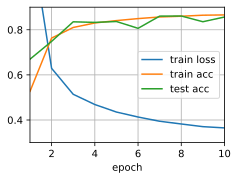

In [5]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))

## Concise Implementation

Using Gluon, all we need to do is add a `Dropout` layer
(also in the `nn` package)
after each fully-connected layer, passing in the dropout probability
as the only argument to its constructor.
During training, the `Dropout` layer will randomly
drop out outputs of the previous layer
(or equivalently, the inputs to the subsequent layer)
according to the specified dropout probability.
When MXNet is not in training mode,
the `Dropout` layer simply passes the data through during testing.

In [6]:
net = nn.Sequential()
net.add(nn.Dense(256, activation="relu"),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(drop_prob1),
        nn.Dense(256, activation="relu"),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(drop_prob2),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

Next, we train and test the model.

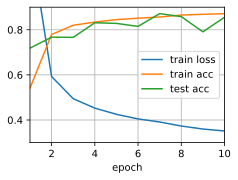

In [7]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## Summary

* Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool to avoid overfitting. Often all three are used jointly.
* Dropout replaces an activation $h$ with a random variable $h'$ with expected value $h$ and with variance given by the dropout probability $p$.
* Dropout is only used during training.


## Exercises

1. Try out what happens if you change the dropout probabilities for layers 1 and 2. In particular, what happens if you switch the ones for both layers?
1. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.
1. Compute the variance of the the activation random variables after applying dropout.
1. Why should you typically not using dropout?
1. If changes are made to the model to make it more complex, such as adding hidden layer units, will the effect of using dropout to cope with overfitting be more obvious?
1. Using the model in this section as an example, compare the effects of using dropout and weight decay. What if dropout and weight decay are used at the same time?
1. What happens if we apply dropout to the individual weights of the weight matrix rather than the activations?
1. Replace the dropout activation with a random variable that takes on values of $[0, \gamma/2, \gamma]$. Can you design something that works better than the binary dropout function? Why might you want to use it? Why not?


## [Discussions](https://discuss.mxnet.io/t/2343)

![](http://d2l.ai/_images/qr_dropout.svg)